# RNN Sentiment

This is the notebook for constructing Theano RNN layers and RNN sentiment classifier. The text for an encoder-decoder can be found in a lot of places, and one reference is here: [http://anie.me/rnn-encoder-decoder/](http://anie.me/rnn-encoder-decoder/). This notebook might also contain a section on vanilla RNN classification task, and a section on RNN autoencoder as well. Note in this implementation, we are being a lot more efficient than some blog posts (like in WildML).

In [1]:
from classifier.rnn_layers import *
from classifier.util import *
from data.sentiment_util import *
from vis.util import *
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Loading Data Sentiment

We use SNLI for inference task (the main purpose of encoder-decoder). We use a partial IMDB dataset provided by Yoon Kim (also preprocessed into numpy form).

In [2]:
data = load_data('data/rt_sentiment_data.npz', 'data/sentiment_vocab.json')

# NOTE: right now this doesn't work, but we want to hold it to 
# the same standard as other code
# Print out all the keys and values from the data dictionary
for k, v in data.iteritems():
  if type(v) == np.ndarray:
    print k, type(v), v.shape, v.dtype
  else:
    print k, type(v), len(v)

loading training sentences...
loading dev sentences...
loading test sentences...
X_val <type 'numpy.ndarray'> (534, 57) int32
X_train <type 'numpy.ndarray'> (9594, 57) int32
y_train <type 'numpy.ndarray'> (9594,) int32
W_embed <type 'numpy.ndarray'> (18768, 300) float32
X_test <type 'numpy.ndarray'> (534, 57) int32
y_val <type 'numpy.ndarray'> (534,) int32
idx_word_map <type 'list'> 18768
y_test <type 'numpy.ndarray'> (534,) int32
word_idx_map <type 'dict'> 18768


## Look at the Data

All the sentences in train, dev, and test are encoded already by indicies. Now we see if we can successfully decode them into actual sentence with our `decode()` function.

In [3]:
print decode_sentences(data['X_train'][1790], data['idx_word_map'])
data['y_train'][1790]

a cleverly crafted but ultimately hollow mockumentary <END>


0

## Vanilla RNN stepforward

We implement the RNN for a single forward step in Theano. We adapted `rnn_stepforward` so it works with theano's special loop construct.

In [12]:
N, D, H = 3, 10, 4

x = np.asarray(np.linspace(-0.4, 0.7, num=N*D).reshape(N, D), dtype='float32')
prev_h = np.asarray(np.linspace(-0.2, 0.5, num=N*H).reshape(N, H), dtype='float32')
Wx = np.asarray(np.linspace(-0.1, 0.9, num=D*H).reshape(D, H), dtype='float32')
Wh = np.asarray(np.linspace(-0.3, 0.7, num=H*H).reshape(H, H), dtype='float32')
b = np.asarray(np.linspace(-0.2, 0.4, num=H), dtype='float32')

x_sym = T.matrix('x')
prev_h_shared = theano.shared(
            value=prev_h,
            name='prev_h',
            borrow=True
        )
Wx_shared = theano.shared(
            value=Wx,
            name='Wx',
            borrow=True
)
Wh_shared = theano.shared(
            value=Wh,
            name='Wh',
            borrow=True
)
b_shared = theano.shared(
            value=b,
            name='b',
            borrow=True
)

next_h, _ = rnn_step_forward(x_sym, prev_h_shared, Wx_shared, Wh_shared, b_shared, 0, T.zeros((N, 1, H)))

get_value_nexth = theano.function([x_sym], next_h)

expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print 'next_h error: ', rel_error(expected_next_h, get_value_nexth(x))

next_h error:  9.608901251e-08


## Theano `scan()` Function

In [4]:
k = T.iscalar("k")
A = T.vector("A")

def power(prior_result, A):
    return prior_result * A

# Symbolic description of the result
# Comment: interesting, so scan has a very high freedom
# any variable of scan can be a symbolic variable passed in...
# meaning, when we have RNN
result, _ = theano.scan(fn=power,
                              outputs_info=T.ones_like(A),  # handles initialization
                              non_sequences=A,
                              n_steps=k)

# We only care about A**k, but scan has provided us with A**1 through A**k.
# Discard the values that we don't care about. Scan is smart enough to
# notice this and not waste memory saving them.
final_result = result[-1]

# compiled function that returns A**k
power = theano.function(inputs=[A,k], outputs=final_result) # , updates=updates

print(power(range(10),2))
print(power(range(10),4))

[  0.   1.   4.   9.  16.  25.  36.  49.  64.  81.]
[  0.00000000e+00   1.00000000e+00   1.60000000e+01   8.10000000e+01
   2.56000000e+02   6.25000000e+02   1.29600000e+03   2.40100000e+03
   4.09600000e+03   6.56100000e+03]


In [6]:
# Now we try something slightly more complex:

N, TS, D, H = 2, 3, 4, 5

x = T.tensor3('x')

x_num = np.asarray(np.linspace(-0.1, 0.3, num=N*TS*D).reshape(N, TS, D), dtype='float32')
h0 = np.asarray(np.linspace(-0.3, 0.1, num=N*H).reshape(N, H), dtype='float32')
Wx = np.asarray(np.linspace(-0.2, 0.4, num=D*H).reshape(D, H), dtype='float32')
Wh = np.asarray(np.linspace(-0.4, 0.1, num=H*H).reshape(H, H), dtype='float32')
b = np.asarray(np.linspace(-0.7, 0.1, num=H), dtype='float32')

h0_shared = theano.shared(
            value=h0,
            name='h0',
            borrow=True
        )

Wx_shared = theano.shared(
            value=Wx,
            name='Wx',
            borrow=True
        )

Wh_shared = theano.shared(
            value=Wh,
            name='Wh',
            borrow=True
        )

b_shared = theano.shared(
            value=b,
            name='b',
            borrow=True
        )

def slice_add(x, prev_h, Wx, Wh, b):
    next_h = T.tanh(T.dot(prev_h, Wh) + T.dot(x, Wx) + b)
    return next_h

result, _ = theano.scan(fn=lambda t, ht: slice_add(x[:, t, :], ht, Wx_shared, Wh_shared, b_shared),
                        sequences=T.arange(TS),
                        outputs_info=h0_shared)

slice_x = theano.function(inputs=[x], outputs=result)

final_res = slice_x(x_num)

print(final_res.shape)

print final_res

(3, 2, 5)
[[[-0.42070749 -0.27279261 -0.11074946  0.0574041   0.22236253]
  [-0.55857474 -0.39065823 -0.19198182  0.02378407  0.23735671]]

 [[-0.39525807 -0.2255466  -0.04094539  0.14649412  0.32397318]
  [-0.27150196 -0.07088803  0.13562937  0.33099726  0.50158769]]

 [[-0.42305112 -0.24223728 -0.04287028  0.15997045  0.35014525]
  [-0.51014829 -0.3052443  -0.06755204  0.17806391  0.40333042]]]


## Vanilla RNN Forward

Now we use `theano.scan()` to implement RNN forward over T sequence. It turns out we need quite some tricks to make this work smoothly.

In [13]:
N, TS, D, H = 2, 3, 4, 5

x = T.tensor3('x')

x_num = np.asarray(np.linspace(-0.1, 0.3, num=N*TS*D).reshape(N, TS, D), dtype='float32')
h0 = np.asarray(np.linspace(-0.3, 0.1, num=N*H).reshape(N, H), dtype='float32')
Wx = np.asarray(np.linspace(-0.2, 0.4, num=D*H).reshape(D, H), dtype='float32')
Wh = np.asarray(np.linspace(-0.4, 0.1, num=H*H).reshape(H, H), dtype='float32')
b = np.asarray(np.linspace(-0.7, 0.1, num=H), dtype='float32')

h0_shared = theano.shared(
            value=h0,
            name='h0',
            borrow=True
        )

Wx_shared = theano.shared(
            value=Wx,
            name='Wx',
            borrow=True
        )

Wh_shared = theano.shared(
            value=Wh,
            name='Wh',
            borrow=True
        )

b_shared = theano.shared(
            value=b,
            name='b',
            borrow=True
        )

rnn_hidden_states = rnn_forward(x, h0_shared, Wx_shared, Wh_shared, b_shared, (N, TS, H))

expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])

get_h = theano.function(inputs=[x], outputs=rnn_hidden_states)

h = get_h(x_num)

print 'h error: ', rel_error(expected_h, h)

h error:  2.24007004401e-07


## LSTM: step forward

Adapting one step LSTM to theano

In [9]:
N, D, H = 3, 4, 5

x_sym = T.matrix('x')

x = np.asarray(np.linspace(-0.4, 1.2, num=N*D).reshape(N, D), dtype='float32')
prev_h = np.asarray(np.linspace(-0.3, 0.7, num=N*H).reshape(N, H), dtype='float32')
prev_c = np.asarray(np.linspace(-0.4, 0.9, num=N*H).reshape(N, H), dtype='float32')
Wx = np.asarray(np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H), dtype='float32')
Wh = np.asarray(np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H), dtype='float32')
b = np.asarray(np.linspace(0.3, 0.7, num=4*H), dtype='float32')

prev_h_shared = theano.shared(
            value=prev_h,
            name='prev_h',
            borrow=True
        )
               
prev_c_shared = theano.shared(
            value=prev_c,
            name='prev_c',
            borrow=True
        )

Wx_shared = theano.shared(
            value=Wx,
            name='Wx',
            borrow=True
        )

Wh_shared = theano.shared(
            value=Wh,
            name='Wh',
            borrow=True
        )

b_shared = theano.shared(
            value=b,
            name='b',
            borrow=True
        )

next_h, next_c = lstm_step_forward(x_sym, prev_h, prev_c, Wx, Wh, b, H)
               
lstm_step_forward_num = theano.function(inputs=[x_sym], outputs=[next_h, next_c])

next_h_num, next_c_num = lstm_step_forward_num(x)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print 'next_h error: ', rel_error(expected_next_h, next_h_num)
print 'next_c error: ', rel_error(expected_next_c, next_c_num)

next_h error:  4.45981854665e-08
next_c error:  4.49625600634e-08


## Vanilla LSTM Forward

In [27]:
N, D, H, TS = 2, 5, 4, 3

x_sym = T.tensor3('x')

x = np.asarray(np.linspace(-0.4, 0.6, num=N*TS*D).reshape(N, TS, D), dtype='float32')
h0 = np.asarray(np.linspace(-0.4, 0.8, num=N*H).reshape(N, H), dtype='float32')
Wx = np.asarray(np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H), dtype='float32')
Wh = np.asarray(np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H), dtype='float32')
b = np.asarray(np.linspace(0.2, 0.7, num=4*H), dtype='float32')

h0_shared = theano.shared(
            value=h0,
            name='h0',
            borrow=True
        )

Wx_shared = theano.shared(
            value=Wx,
            name='Wx',
            borrow=True
        )

Wh_shared = theano.shared(
            value=Wh,
            name='Wh',
            borrow=True
        )

b_shared = theano.shared(
            value=b,
            name='b',
            borrow=True
        )

h_sym = lstm_forward(x_sym, h0, Wx, Wh, b, (N, TS, H))

get_lstm_forward_num = theano.function(inputs=[x_sym], outputs=[h_sym])

h = get_lstm_forward_num(x)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print 'h error: ', rel_error(expected_h, h)

h error:  2.8783979953e-07


## RNN Dropout Without Memory Loss

We implement a hidden state to hidden state dropout on block gate.

## RNN Batch Normalization

We do not implement the LSTM Batch Normalization suggested by this paper [http://arxiv.org/pdf/1603.09025v3.pdf](http://arxiv.org/pdf/1603.09025v3.pdf), we start by implementing a simple Batch Normalization for RNN first.

## Building Up RNN Encoder

Unfortunately our RNN encoder is not as flexible as our CNN net.Most parameters and weights are initialized inside the RNN. We print out parameters, and final loos to examine them.

In [9]:
encoder = RNNEncoder(data['word_idx_map'], data['idx_word_map'], data['W_embed'], max_seq_length=57, batch_size=50)
print encoder.params.keys()

['b', 'W_embed', 'W_proj', 'Wh', 'b_proj', 'Wx']


We load in a small amount of data: 500 sentences to test if we can get a valid loss from RNNEncoder.

In [10]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'][:num_train/2],
  'y_val': data['y_val'][:num_train/2],
}

X = T.imatrix('X')
y = T.ivector('y')

loss = encoder.loss(X, y)

run_once = theano.function([X, y], [loss])

run_once(small_data['X_train'], small_data['y_train'])

[array(0.671669602394104, dtype=float32)]

## RNN Encoder Solver

Now we construct a solver and run on a small set.

In [11]:
from classifier.rnn_encoder_solver import EncoderSolver

num_train = 200
batch_size = 20
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'][:num_train/2],
  'y_val': data['y_val'][:num_train/2],
}

X = T.imatrix('X')
y = T.ivector('y')

# max_seq_length = 57
encoder = RNNEncoder(data['word_idx_map'], data['idx_word_map'], data['W_embed'], max_seq_length=20, batch_size=batch_size)
solver = EncoderSolver(encoder,
                       small_data, X, y,
                num_epochs=20, batch_size=batch_size,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=True, print_every=10)
solver.train()

(Iteration 1 / 200) loss: 0.725732
(Epoch 0 / 20) train acc: 0.700000; val_acc: 0.450000
(Epoch 1 / 20) train acc: 0.500000; val_acc: 0.550000
(Iteration 11 / 200) loss: 1.224356
(Epoch 2 / 20) train acc: 0.250000; val_acc: 0.650000
(Iteration 21 / 200) loss: 0.677460
(Epoch 3 / 20) train acc: 0.450000; val_acc: 0.450000
(Iteration 31 / 200) loss: 0.671143
(Epoch 4 / 20) train acc: 0.400000; val_acc: 0.600000
(Iteration 41 / 200) loss: 0.737899
(Epoch 5 / 20) train acc: 0.650000; val_acc: 0.550000
(Iteration 51 / 200) loss: 0.784658
(Epoch 6 / 20) train acc: 0.750000; val_acc: 0.350000
(Iteration 61 / 200) loss: 0.297162
(Epoch 7 / 20) train acc: 0.650000; val_acc: 0.600000
(Iteration 71 / 200) loss: 0.703480
(Epoch 8 / 20) train acc: 0.750000; val_acc: 0.500000
(Iteration 81 / 200) loss: 0.554789
(Epoch 9 / 20) train acc: 0.700000; val_acc: 0.500000
(Iteration 91 / 200) loss: 0.700895
(Epoch 10 / 20) train acc: 0.700000; val_acc: 0.350000
(Iteration 101 / 200) loss: 0.539087
(Epoch 11

In [13]:
val_loss, val_acc = solver.check_accuracy(small_data['X_val'], small_data['y_val'], batch_size=batch_size)
print "val_acc", val_acc

val_acc 0.699999988079


We **validate** our model by trying to overfit the data, and it proves to be the case.

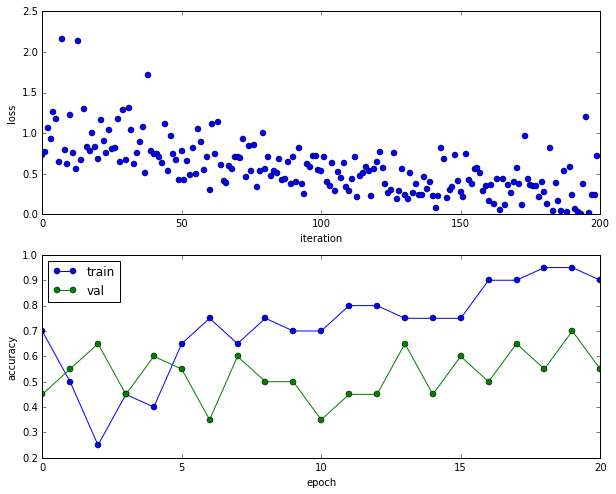

In [14]:
# plot loss history
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [10]:
from classifier.rnn_encoder_solver import EncoderSolver

num_train = 9500
batch_size = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'][:500],
  'y_val': data['y_val'][:500],
}

X = T.imatrix('X')
y = T.ivector('y')

# max_seq_length = 57
encoder = RNNEncoder(data['word_idx_map'], data['idx_word_map'], data['W_embed'], max_seq_length=57, batch_size=batch_size)
solver = EncoderSolver(encoder,
                       small_data, X, y,
                num_epochs=100, batch_size=batch_size,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=True, print_every=10)
solver.train()

(Iteration 1 / 19000) loss: 0.710787
(Epoch 0 / 100) train acc: 0.420000; val_acc: 0.580000
(Iteration 11 / 19000) loss: 0.657665


KeyboardInterrupt: 